# Prometheus Data Analysis
This notebook loads, processes, and explores data recorded by the benchmarked IoT platform prototype monitoring subsystem. During the benchmark execution, OpenTelemetry agents and the HiveMQ Prometheus extension were used to collect measurements. These recorded measurements were stored in the Prometheus time-series database, which records are part of the logs provided in the replication package. Instructions on extracting the recorded measurements and running them in a new instance of Prometheus can be found in the README in the root directory of this repository.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from matplotlib import colormaps
import matplotlib.dates as mdates
import pandas as pd

## JSON data file paths

In [2]:
cwd = os.getcwd()
transformer_logs= f'{cwd}/../transformer/logs/'
incomming_file='brokers_incomming_msgs.json'
outgoing_file='brokers_outgoing_msgs.json'

## Benchmark Parameters

Benchmark parameters used in the setup for execution of the system under test.

In [3]:
auts=['aut1_15b','aut1_29b','aut2']
qoss =['qos0', 'qos1', 'qos2']
gateways=['provider1.gateway1','provider1.gateway2','provider2.gateway1']
gateways_payloads=['125KB','35KB','1.5KB']
# Brokers Services
source_brokers=['ingestion-service1','ingestion-service2']
destination_brokers=['core-service']

## JSON Parser

In [4]:
def parse_json_to_list(json_obj, aut, qos):
    if json_obj['status'] != 'success':
        raise ValueError("Data retrieval was not successful")
    
    results = json_obj['data']['result']
    
    data_list = []
    for entry in results:
        metric_name = entry['metric']['__name__']
        instance = entry['metric'].get('instance', 'N/A')
        job = entry['metric'].get('job', 'N/A')
        exported_instance = entry['metric'].get('exported_instance', 'N/A')
        exported_job = entry['metric'].get('exported_job', 'N/A')
        
        values = entry['values']
        
        for value in values:
            timestamp, count = value
            # Convert timestamp from seconds to nanoseconds
            nanosecond_timestamp = int(float(timestamp) * 1e9)
            data_list.append((
                np.datetime64(nanosecond_timestamp,'ns'), 
                float(count), 
                metric_name, 
                instance, 
                job, 
                exported_instance, 
                exported_job, 
                aut, 
                qos
            ))
    
    return data_list

In [5]:
def get_last_data_points_for_jobs(numpy_array, brokers, metric_name):
    last_data_points = []
    
    for broker in brokers:
        # Filter data by broker and metric names
        broker_data = numpy_array[(numpy_array['job'] == broker) & (numpy_array['metric_name'] == metric_name)]
        if len(broker_data) > 0:
            sorted_broker_data = np.sort(broker_data, order='timestamp')
            last_data_point = sorted_broker_data[-1]
            last_data_points.append(last_data_point)
    
    return last_data_points

In [6]:
# Function to summarize data points by 'aut' and 'qos'
def summarize_data_points_by_aut_and_qos(data_points):
    summary = {}
    for data_point in data_points:
        key = (data_point['aut'], data_point['qos'])
        if key not in summary:
            summary[key] = 0
        summary[key] += data_point['value']
    return summary

In [7]:
# Function to get last data point by key (aut, qos, job)
def get_last_data_points_by_key(data_array, key_fields=['aut', 'qos', 'job']):
    last_data_points = {}
    
    for data_point in data_array:
        key = tuple(data_point[field] for field in key_fields)
        if key not in last_data_points or data_point['timestamp'] > last_data_points[key]['timestamp']:
            last_data_points[key] = data_point
    
    return last_data_points

In [8]:
def plot_time_series_grouped(data_array):
    # Extract unique values for aut, qos, job, and metric_name
    aut_values = np.unique(data_array['aut'])
    qos_values = np.unique(data_array['qos'])
    job_values = np.unique(data_array['job'])
    metric_name_values = np.unique(data_array['metric_name'])
    
    # Define markers for distinction
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', '+', 'x']
    colormap = colormaps['tab20']  # Use updated colormap retrieval syntax
    
    # Plot each combination of aut and qos separately
    for aut in aut_values:
        for qos in qos_values:
            plt.figure(figsize=(14, 8))
            plt.title(f'Metrics over Time for {aut.upper()} and {qos.upper()}')
            plt.xlabel('Timestamp')
            plt.ylabel('Value')
            plt.grid(True)
            
            # Iterate through job and metric_name combinations
            unique_combinations = np.array([(job, metric_name) for job in job_values for metric_name in metric_name_values])
            num_combinations = len(unique_combinations)
            
            for idx, (job, metric_name) in enumerate(unique_combinations):
                # marker = markers[idx % len(markers)]
                # color = colormap(idx / num_combinations)  # Get color from colormap
                group_data = data_array[(data_array['aut'] == aut) & 
                                        (data_array['qos'] == qos) & 
                                        (data_array['job'] == job) & 
                                        (data_array['metric_name'] == metric_name)]
                
                if len(group_data) > 0 and metric_name == 'com_hivemq_messages_incoming_publish_count':
                    if job == 'core-service':
                        continue
                    if job == 'ingestion-service1':
                        plt.plot(group_data['timestamp'], group_data['value'], linestyle='-', 
                                 label=f'job={job}, metric_name={metric_name}',linewidth=2)
                    if job == 'ingestion-service2':
                        plt.plot(group_data['timestamp'], group_data['value'], linestyle=':', 
                                 label=f'job={job}, metric_name={metric_name}',linewidth=2)
                if len(group_data) > 0 and metric_name == 'com_hivemq_messages_outgoing_publish_count':
                    if job != 'core-service':
                        continue
                    plt.plot(group_data['timestamp'], group_data['value'], linestyle='-.', 
                             label=f'job={job}, metric_name={metric_name}',linewidth=5)
            
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
            plt.show()

## Load JSON data

In [9]:
# Define the dtype for the structured array
dtype = np.dtype([
    ('timestamp', 'datetime64[ns]'),
    ('value', 'f8'),
    ('metric_name', 'U64'),
    ('instance', 'U64'),
    ('job', 'U64'),
    ('exported_instance', 'U64'),
    ('exported_job', 'U64'),
    ('aut', 'U64'),
    ('qos', 'U64')
])

# Initialize a master list to collect all data
brokers_data = []

for aut in auts:
    for qos in qoss:
        log_folder = os.path.join(transformer_logs, aut, qos)

        if incomming_file in os.listdir(log_folder) and os.path.isfile(os.path.join(log_folder, incomming_file)):
            print(f'Found JSON data for {aut} {qos}: {os.path.join(log_folder, incomming_file)}')
            with open(os.path.join(log_folder, incomming_file), 'r') as file:
                json_data= file.read()
                incomming_data = json.loads(json_data)
                brokers_data.extend(parse_json_to_list(incomming_data,aut,qos))

        if outgoing_file in os.listdir(log_folder) and os.path.isfile(os.path.join(log_folder, outgoing_file)):
            print(f'Found JSON data for {aut} {qos}: {os.path.join(log_folder, outgoing_file)}')
            with open(os.path.join(log_folder, outgoing_file), 'r') as file:
                json_data= file.read()
                outgoing_data = json.loads(json_data)
                brokers_data.extend(parse_json_to_list(outgoing_data,aut,qos))
 

# Convert master_data list into a NumPy array
numpy_array = np.array(brokers_data, dtype=dtype)

Found JSON data for aut1_15b qos0: /home/keila/smartoceanplatform/icsa25/mqtt_benchmark/data_analysis/../transformer/logs/aut1_15b/qos0/brokers_incomming_msgs.json
Found JSON data for aut1_15b qos0: /home/keila/smartoceanplatform/icsa25/mqtt_benchmark/data_analysis/../transformer/logs/aut1_15b/qos0/brokers_outgoing_msgs.json
Found JSON data for aut1_15b qos1: /home/keila/smartoceanplatform/icsa25/mqtt_benchmark/data_analysis/../transformer/logs/aut1_15b/qos1/brokers_incomming_msgs.json
Found JSON data for aut1_15b qos1: /home/keila/smartoceanplatform/icsa25/mqtt_benchmark/data_analysis/../transformer/logs/aut1_15b/qos1/brokers_outgoing_msgs.json
Found JSON data for aut1_15b qos2: /home/keila/smartoceanplatform/icsa25/mqtt_benchmark/data_analysis/../transformer/logs/aut1_15b/qos2/brokers_incomming_msgs.json
Found JSON data for aut1_15b qos2: /home/keila/smartoceanplatform/icsa25/mqtt_benchmark/data_analysis/../transformer/logs/aut1_15b/qos2/brokers_outgoing_msgs.json
Found JSON data for

## Get last data point for incomming and outgoing pubished messages

In [10]:
# Filter data based on metric names
metric_names = ['com_hivemq_messages_outgoing_publish_count', 'com_hivemq_messages_incoming_publish_count']
incomming_np = numpy_array[(numpy_array['metric_name'] == 'com_hivemq_messages_incoming_publish_count')]

outgoing_np = numpy_array[(numpy_array['metric_name'] == 'com_hivemq_messages_outgoing_publish_count')]

# Get the last data points summarized by aut, qos, and job
last_incomming_data_points_summary = get_last_data_points_by_key(incomming_np)

# Get the last data points summarized by aut, qos, and job
last_outgoing_data_points_summary = get_last_data_points_by_key(outgoing_np)

# Print summarized data points by (aut, qos, job)
for key, data_point in last_incomming_data_points_summary.items():
    print(f"aut={key[0]}, qos={key[1]}, job={key[2]}")
    print(f"Timestamp: {data_point['timestamp']}, Value: {data_point['value']}, Metric: {data_point['metric_name']}")
    print()

# Print summarized data points by (aut, qos, job)
for key, data_point in last_outgoing_data_points_summary.items():
    print(f"aut={key[0]}, qos={key[1]}, job={key[2]}")
    print(f"Timestamp: {data_point['timestamp']}, Value: {data_point['value']}, Metric: {data_point['metric_name']}")
    print()

aut=aut1_15b, qos=qos0, job=core-service
Timestamp: 2024-11-09T17:56:18.017999872, Value: 20042.0, Metric: com_hivemq_messages_incoming_publish_count

aut=aut1_15b, qos=qos0, job=ingestion-service1
Timestamp: 2024-11-09T17:56:28.844999936, Value: 53.0, Metric: com_hivemq_messages_incoming_publish_count

aut=aut1_15b, qos=qos0, job=ingestion-service2
Timestamp: 2024-11-09T17:56:32.255000064, Value: 19993.0, Metric: com_hivemq_messages_incoming_publish_count

aut=aut1_15b, qos=qos1, job=core-service
Timestamp: 2024-11-08T21:35:18.017999872, Value: 40000.0, Metric: com_hivemq_messages_incoming_publish_count

aut=aut1_15b, qos=qos1, job=ingestion-service1
Timestamp: 2024-11-08T21:36:28.844999936, Value: 20000.0, Metric: com_hivemq_messages_incoming_publish_count

aut=aut1_15b, qos=qos1, job=ingestion-service2
Timestamp: 2024-11-08T21:36:17.249999872, Value: 20000.0, Metric: com_hivemq_messages_incoming_publish_count

aut=aut1_15b, qos=qos2, job=core-service
Timestamp: 2024-11-08T06:59:48.0

In [11]:
# Convert to pandas DataFrame
df = pd.DataFrame(numpy_array)

# Step 1: Identify the last timestamp for each group
last_timestamps = df.groupby(['aut', 'qos', 'job', 'metric_name'])['timestamp'].max().reset_index()

# Step 2: Merge DataFrame with last timestamps to filter the rows with the last timestamp
df_last = pd.merge(df, last_timestamps, on=['aut', 'qos', 'job', 'metric_name', 'timestamp'], how='inner')

# Filter only the rows with metric name "com_hivemq_messages_incoming_publish_count" and job "core-service"
incomming_dest_broker = df_last[(df_last['metric_name'] == 'com_hivemq_messages_incoming_publish_count') & 
                      (df_last['job'] == 'core-service')]

# Print the filtered values for each combination of 'aut' and 'qos'
for (aut, qos), group in incomming_dest_broker.groupby(['aut', 'qos']):
    value = group['value'].iloc[0]  # Assuming there is only one row per group after filtering by last timestamp
    print(f"aut: {aut}, qos: {qos}")
    print(f'Received Messages (Dest. Brokers): {value/10}')

# Filter only the rows with metric name "com_hivemq_messages_outgoing_publish_count" and job "core-service"
outgoing_dest_broker = df_last[(df_last['metric_name'] == 'com_hivemq_messages_outgoing_publish_count') & 
                      (df_last['job'] == 'core-service')]

# Print the filtered values for each combination of 'aut' and 'qos'
for (aut, qos), group in outgoing_dest_broker.groupby(['aut', 'qos']):
    value = group['value'].iloc[0]  # Assuming there is only one row per group after filtering by last timestamp
    print(f"aut: {aut}, qos: {qos}")
    print(f'Published Messages (Dest. Brokers): {value/10}')

aut: aut1_15b, qos: qos0
Received Messages (Dest. Brokers): 2004.2
aut: aut1_15b, qos: qos1
Received Messages (Dest. Brokers): 4000.0
aut: aut1_15b, qos: qos2
Received Messages (Dest. Brokers): 4000.0
aut: aut1_29b, qos: qos0
Received Messages (Dest. Brokers): 2002.4
aut: aut1_29b, qos: qos1
Received Messages (Dest. Brokers): 4000.0
aut: aut1_29b, qos: qos2
Received Messages (Dest. Brokers): 4000.0
aut: aut2, qos: qos0
Received Messages (Dest. Brokers): 2004.7
aut: aut2, qos: qos1
Received Messages (Dest. Brokers): 4000.0
aut: aut2, qos: qos2
Received Messages (Dest. Brokers): 4000.0
aut: aut1_15b, qos: qos0
Published Messages (Dest. Brokers): 2004.2
aut: aut1_15b, qos: qos1
Published Messages (Dest. Brokers): 4000.0
aut: aut1_15b, qos: qos2
Published Messages (Dest. Brokers): 4000.0
aut: aut1_29b, qos: qos0
Published Messages (Dest. Brokers): 2002.4
aut: aut1_29b, qos: qos1
Published Messages (Dest. Brokers): 4000.0
aut: aut1_29b, qos: qos2
Published Messages (Dest. Brokers): 4000.0
a

In [276]:
# Filter only the rows with metric name "com_hivemq_messages_incoming_publish_count" and job "core-service"
incomming_dest_broker = df_last[(df_last['metric_name'] == 'com_hivemq_messages_incoming_publish_count') & 
                      (df_last['job'] != 'core-service')]
# Print the filtered values for each combination of 'aut' and 'qos'
for (aut, qos), group in incomming_dest_broker.groupby(['aut', 'qos']):
    value = group['value'].sum()
    print(f"aut: {aut}, qos: {qos}")
    print(f'Received Messages (Source Brokers): {value/10}')

# Filter only the rows with metric name "com_hivemq_messages_outgoing_publish_count" and job "core-service"
outgoing_dest_broker = df_last[(df_last['metric_name'] == 'com_hivemq_messages_outgoing_publish_count') & 
                      (df_last['job'] != 'core-service')]

# Print the filtered values for each combination of 'aut' and 'qos'
for (aut, qos), group in outgoing_dest_broker.groupby(['aut', 'qos']):
    value = group['value'].sum()
    print(f"aut: {aut}, qos: {qos}")
    print(f'Published Messages (Source Brokers): {value/10}')

aut: aut1_15b, qos: qos0
Received Messages (Source Brokers): 2004.6
aut: aut1_15b, qos: qos1
Received Messages (Source Brokers): 4000.0
aut: aut1_15b, qos: qos2
Received Messages (Source Brokers): 4000.0
aut: aut1_29b, qos: qos0
Received Messages (Source Brokers): 2003.2
aut: aut1_29b, qos: qos1
Received Messages (Source Brokers): 4000.0
aut: aut1_29b, qos: qos2
Received Messages (Source Brokers): 4000.0
aut: aut2, qos: qos0
Received Messages (Source Brokers): 2004.9
aut: aut2, qos: qos1
Received Messages (Source Brokers): 4000.0
aut: aut2, qos: qos2
Received Messages (Source Brokers): 4000.0
aut: aut1_15b, qos: qos0
Published Messages (Source Brokers): 2004.5
aut: aut1_15b, qos: qos1
Published Messages (Source Brokers): 4000.0
aut: aut1_15b, qos: qos2
Published Messages (Source Brokers): 4000.0
aut: aut1_29b, qos: qos0
Published Messages (Source Brokers): 2003.0
aut: aut1_29b, qos: qos1
Published Messages (Source Brokers): 4000.0
aut: aut1_29b, qos: qos2
Published Messages (Source Bro

## Plot Data

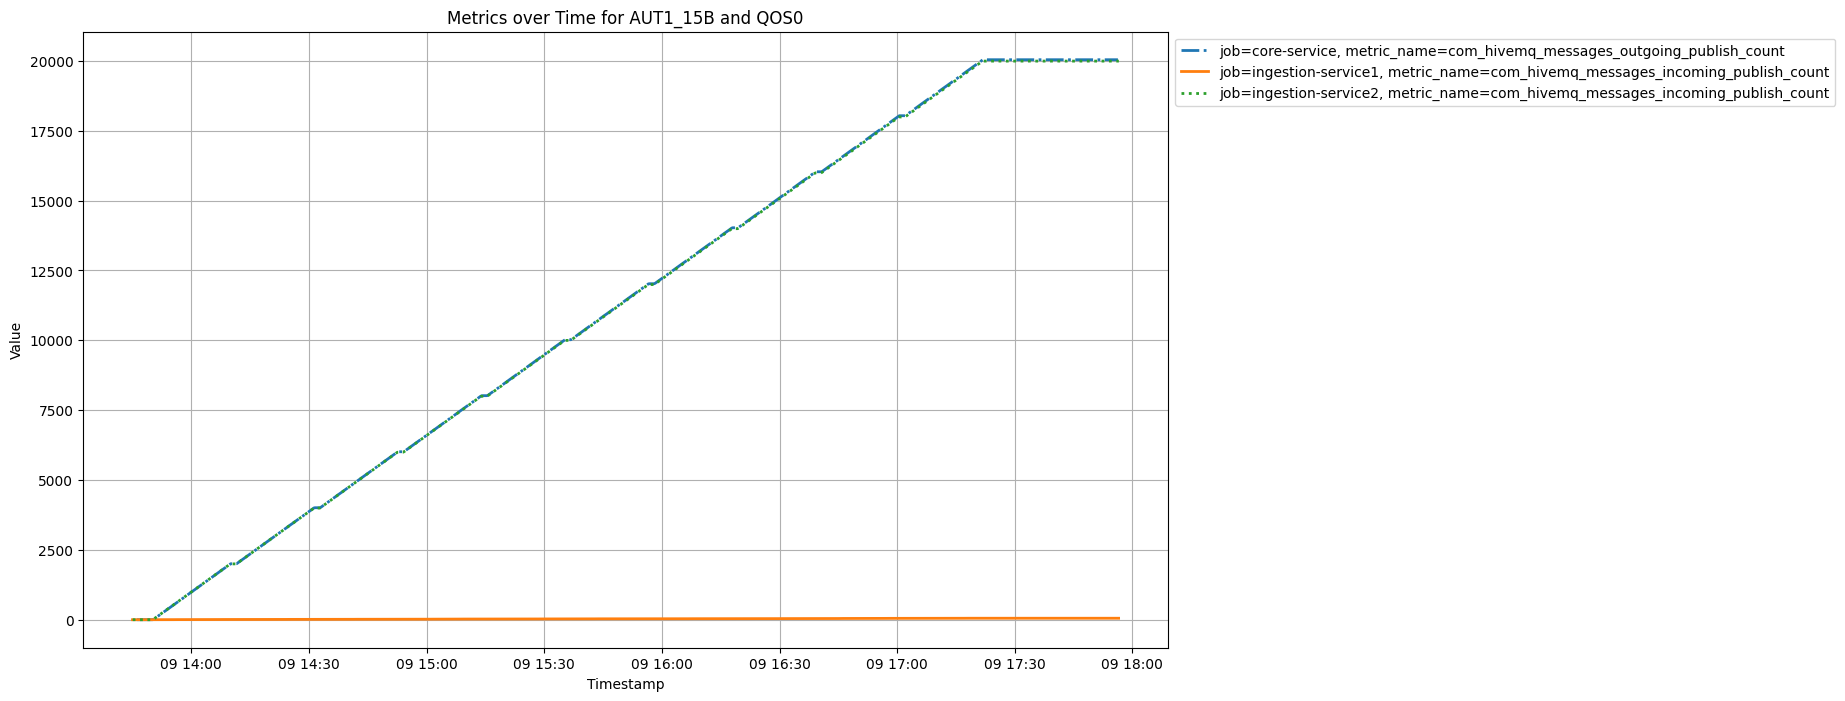

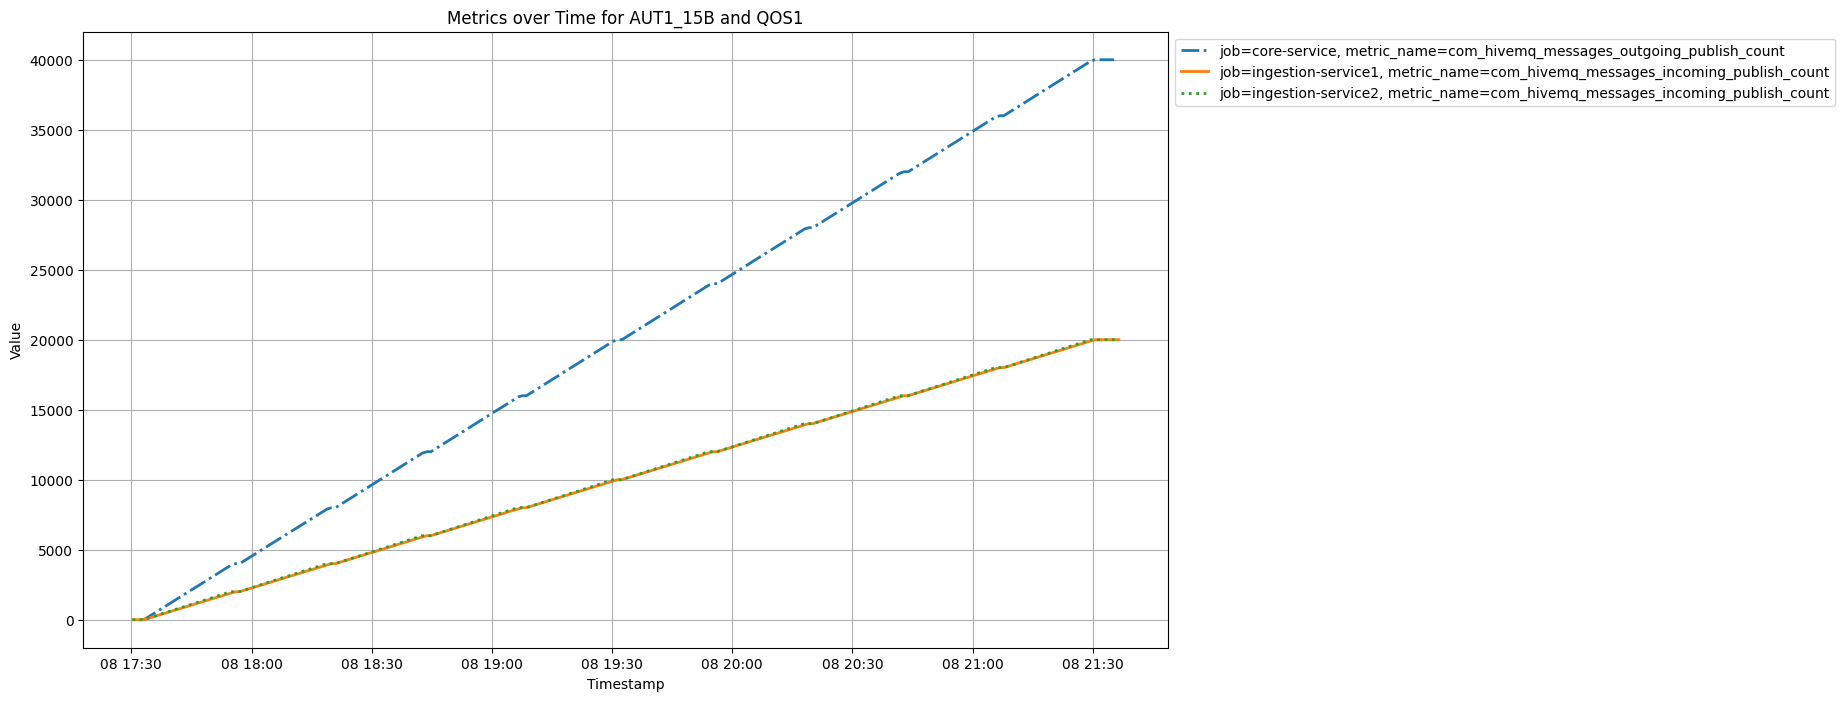

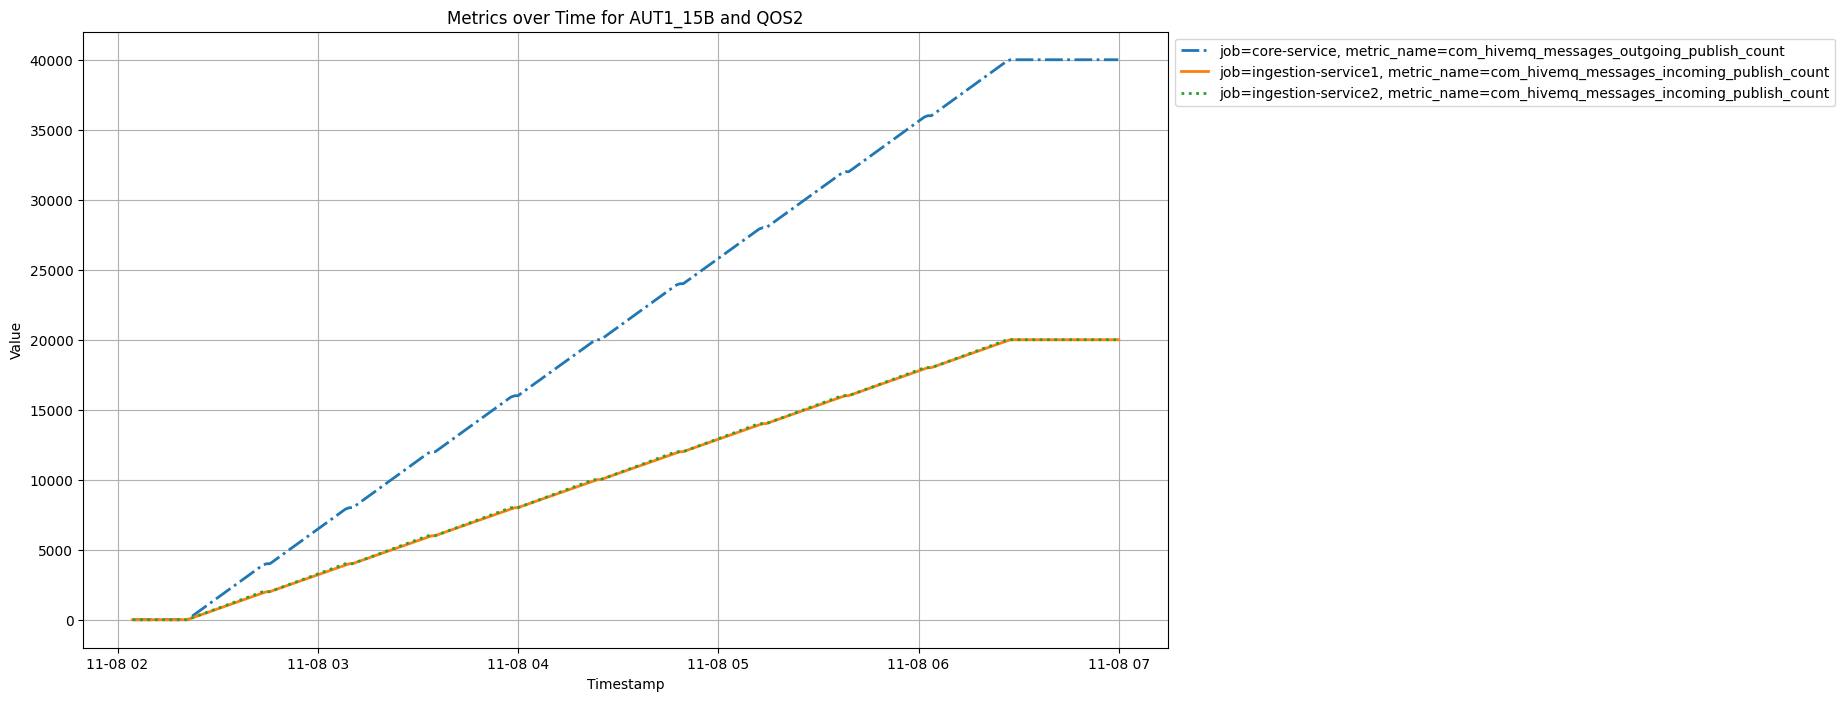

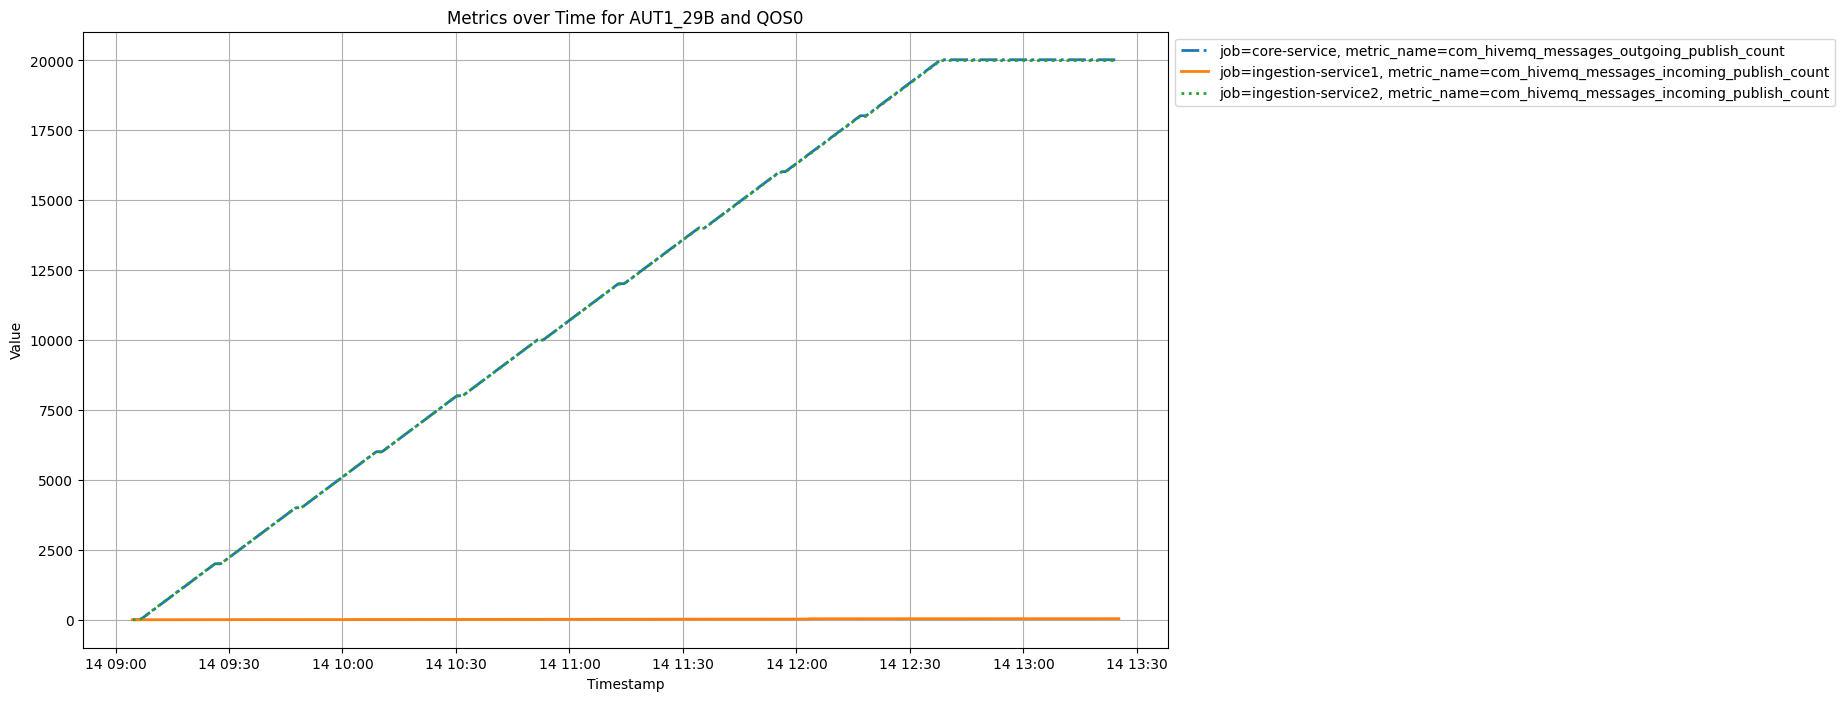

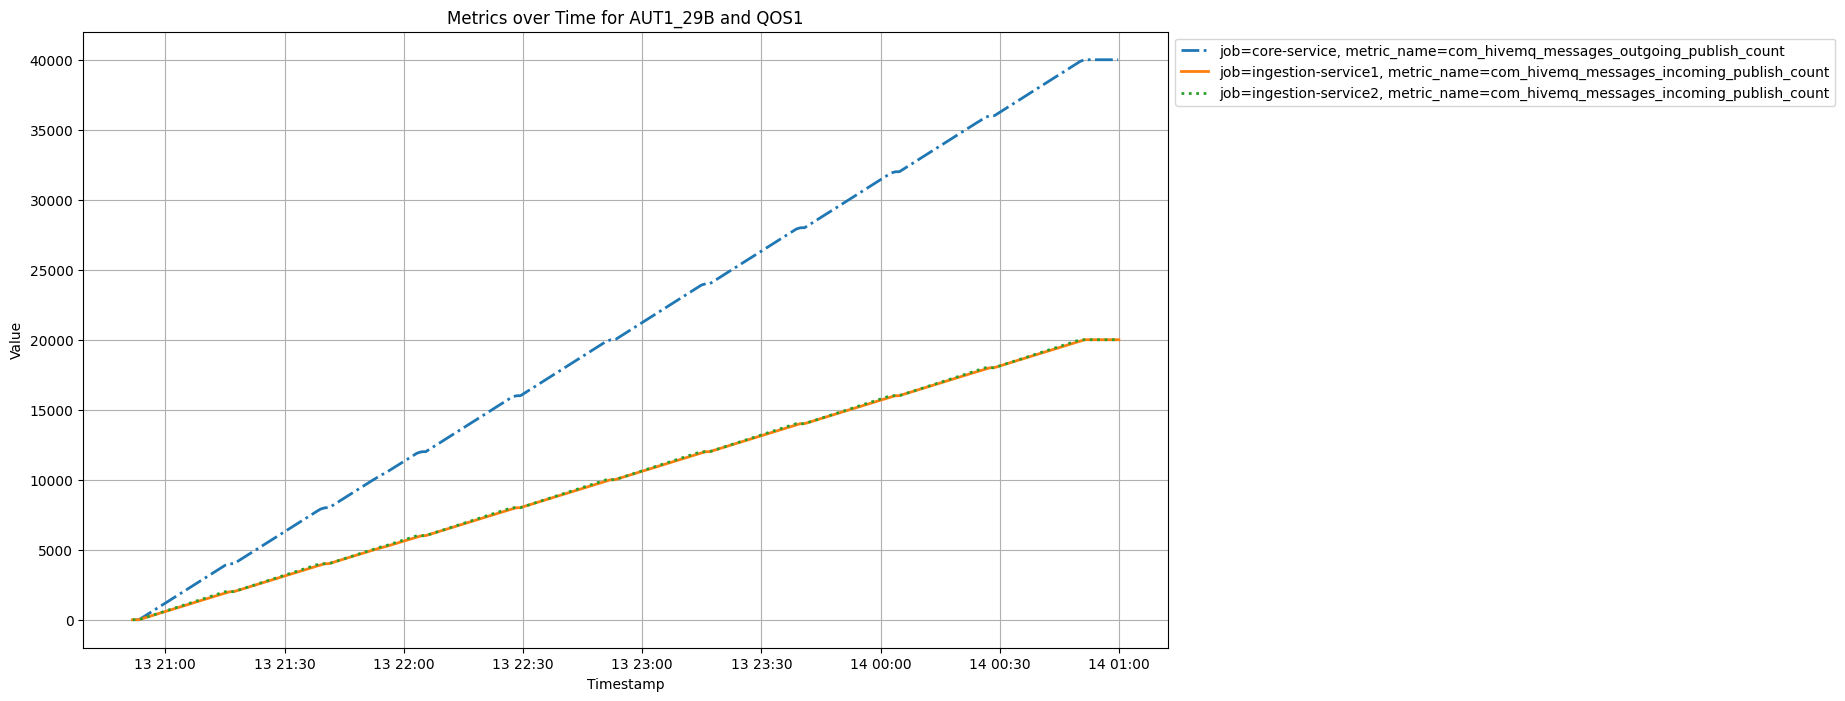

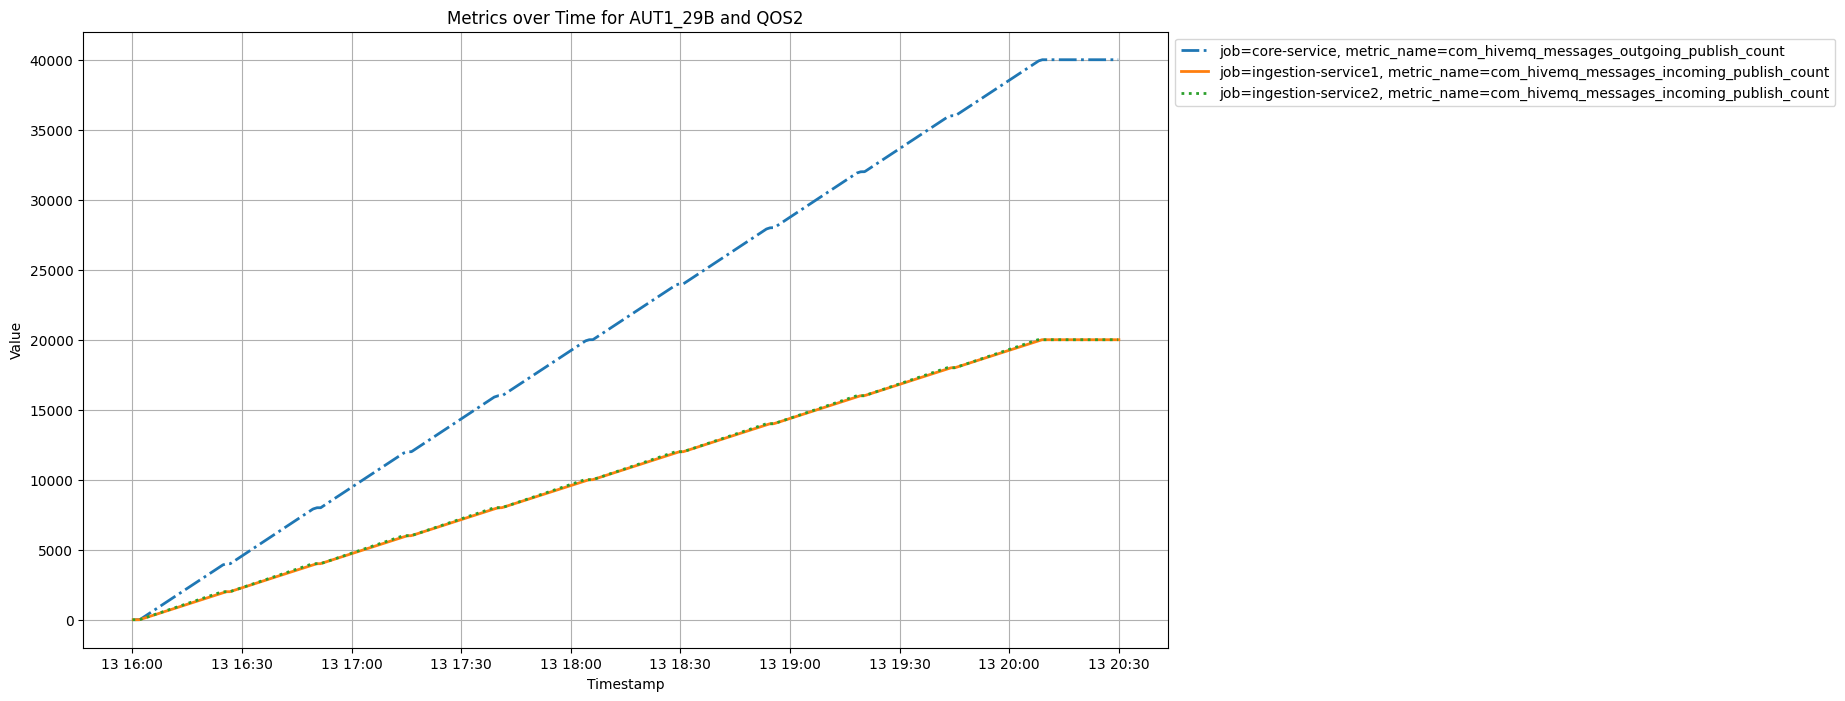

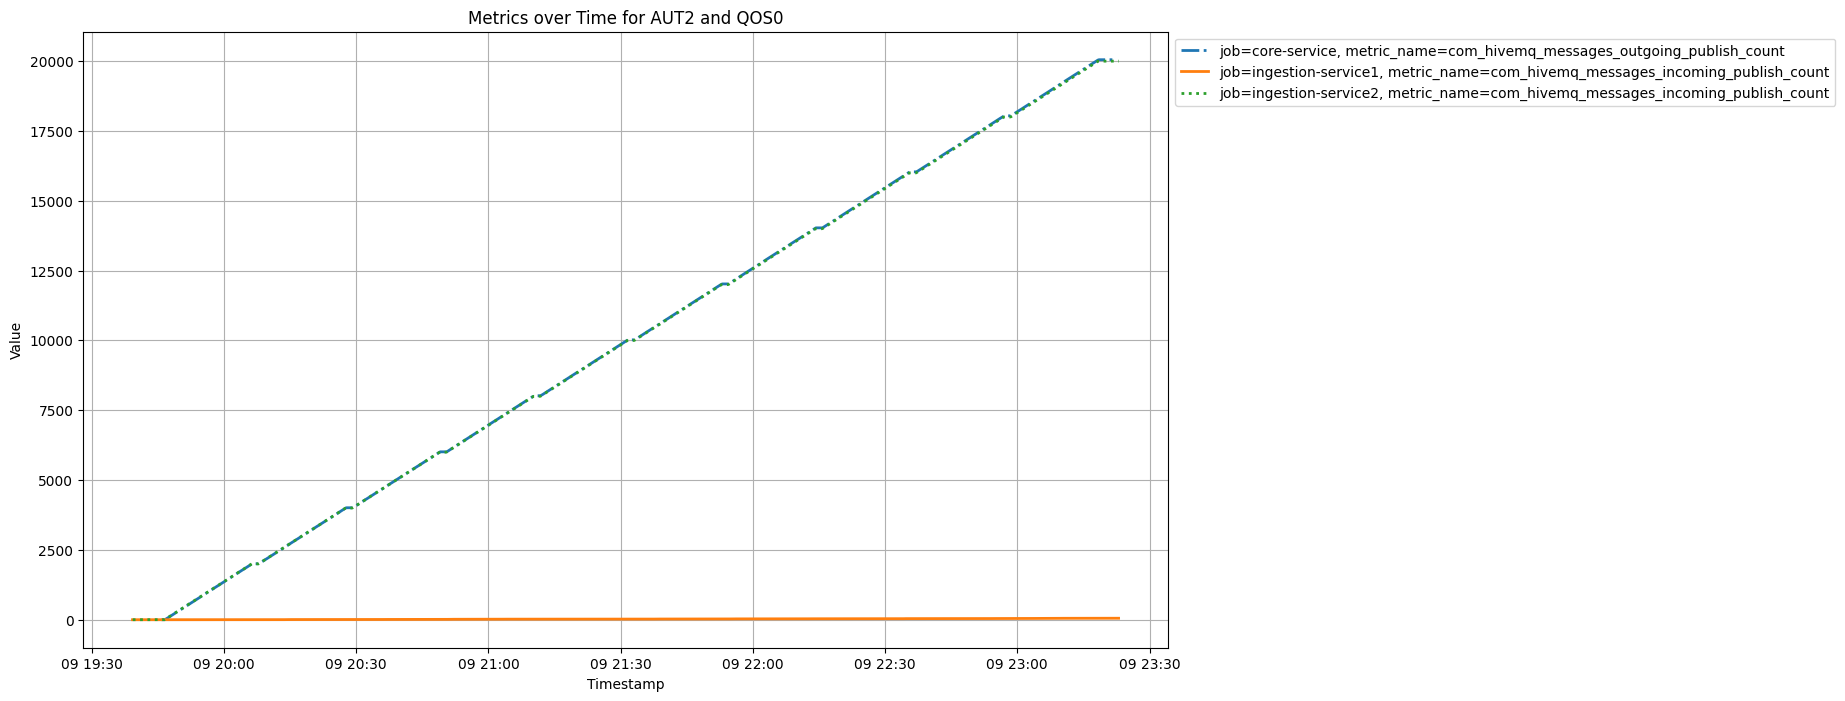

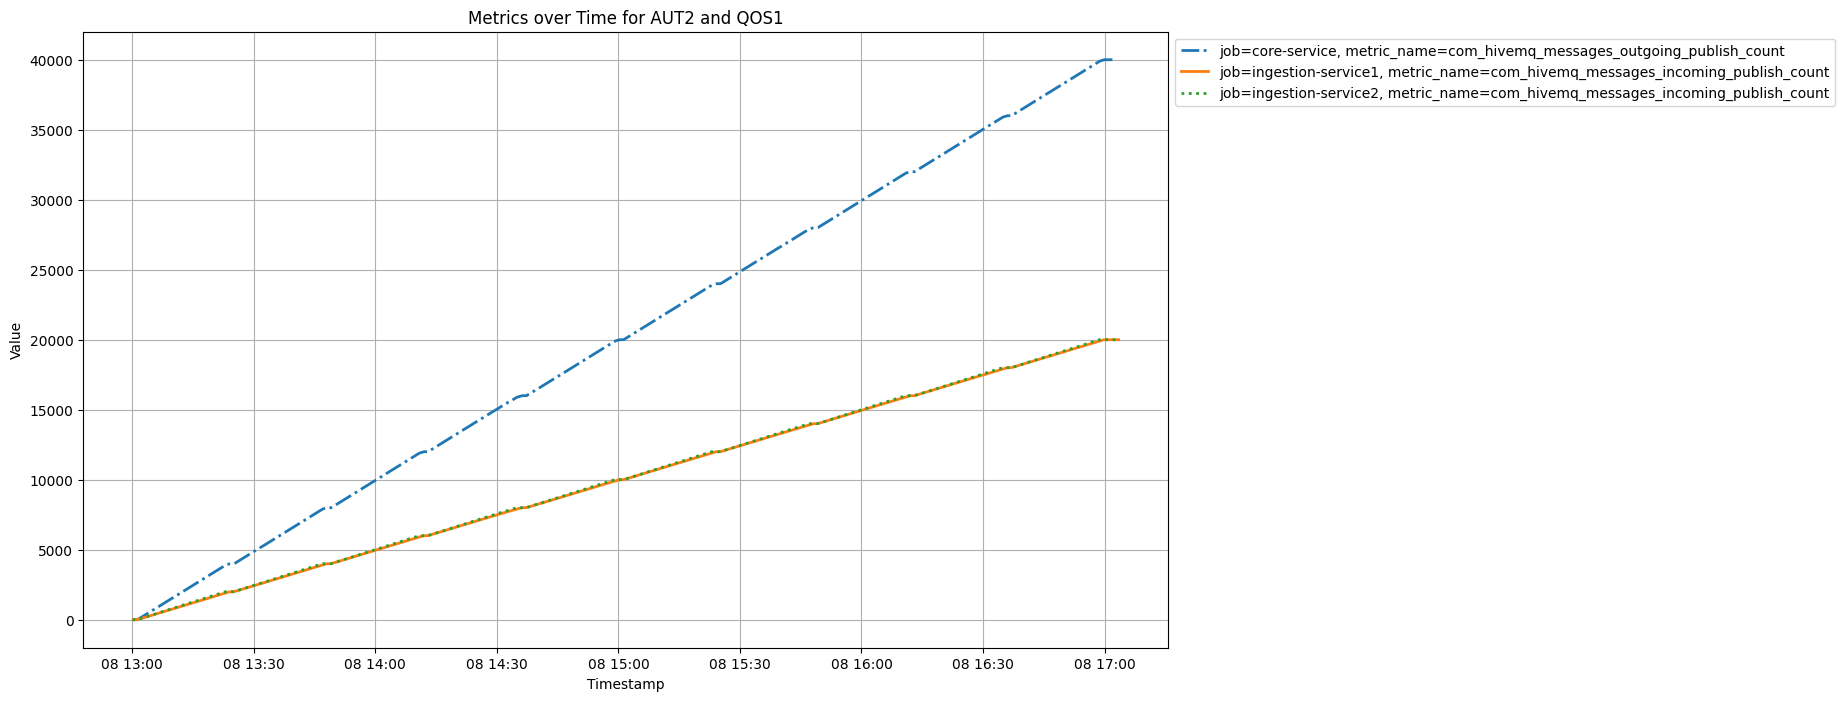

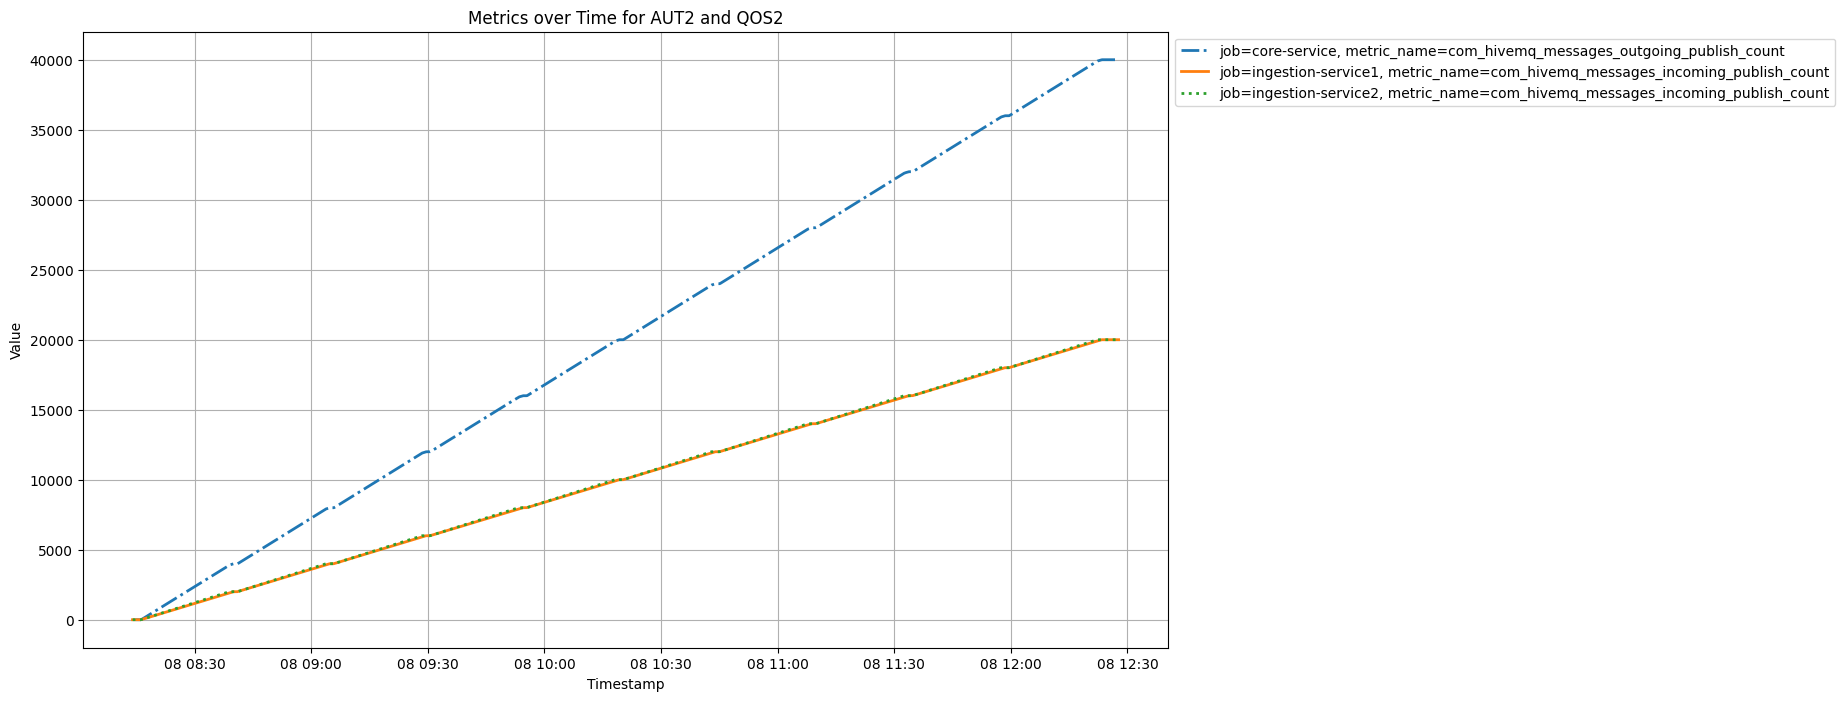

In [164]:
# Plot the time series grouped by aut, qos, job, and metric_name
plot_time_series_grouped(numpy_array)

### Arrange plots in (2,5) grid

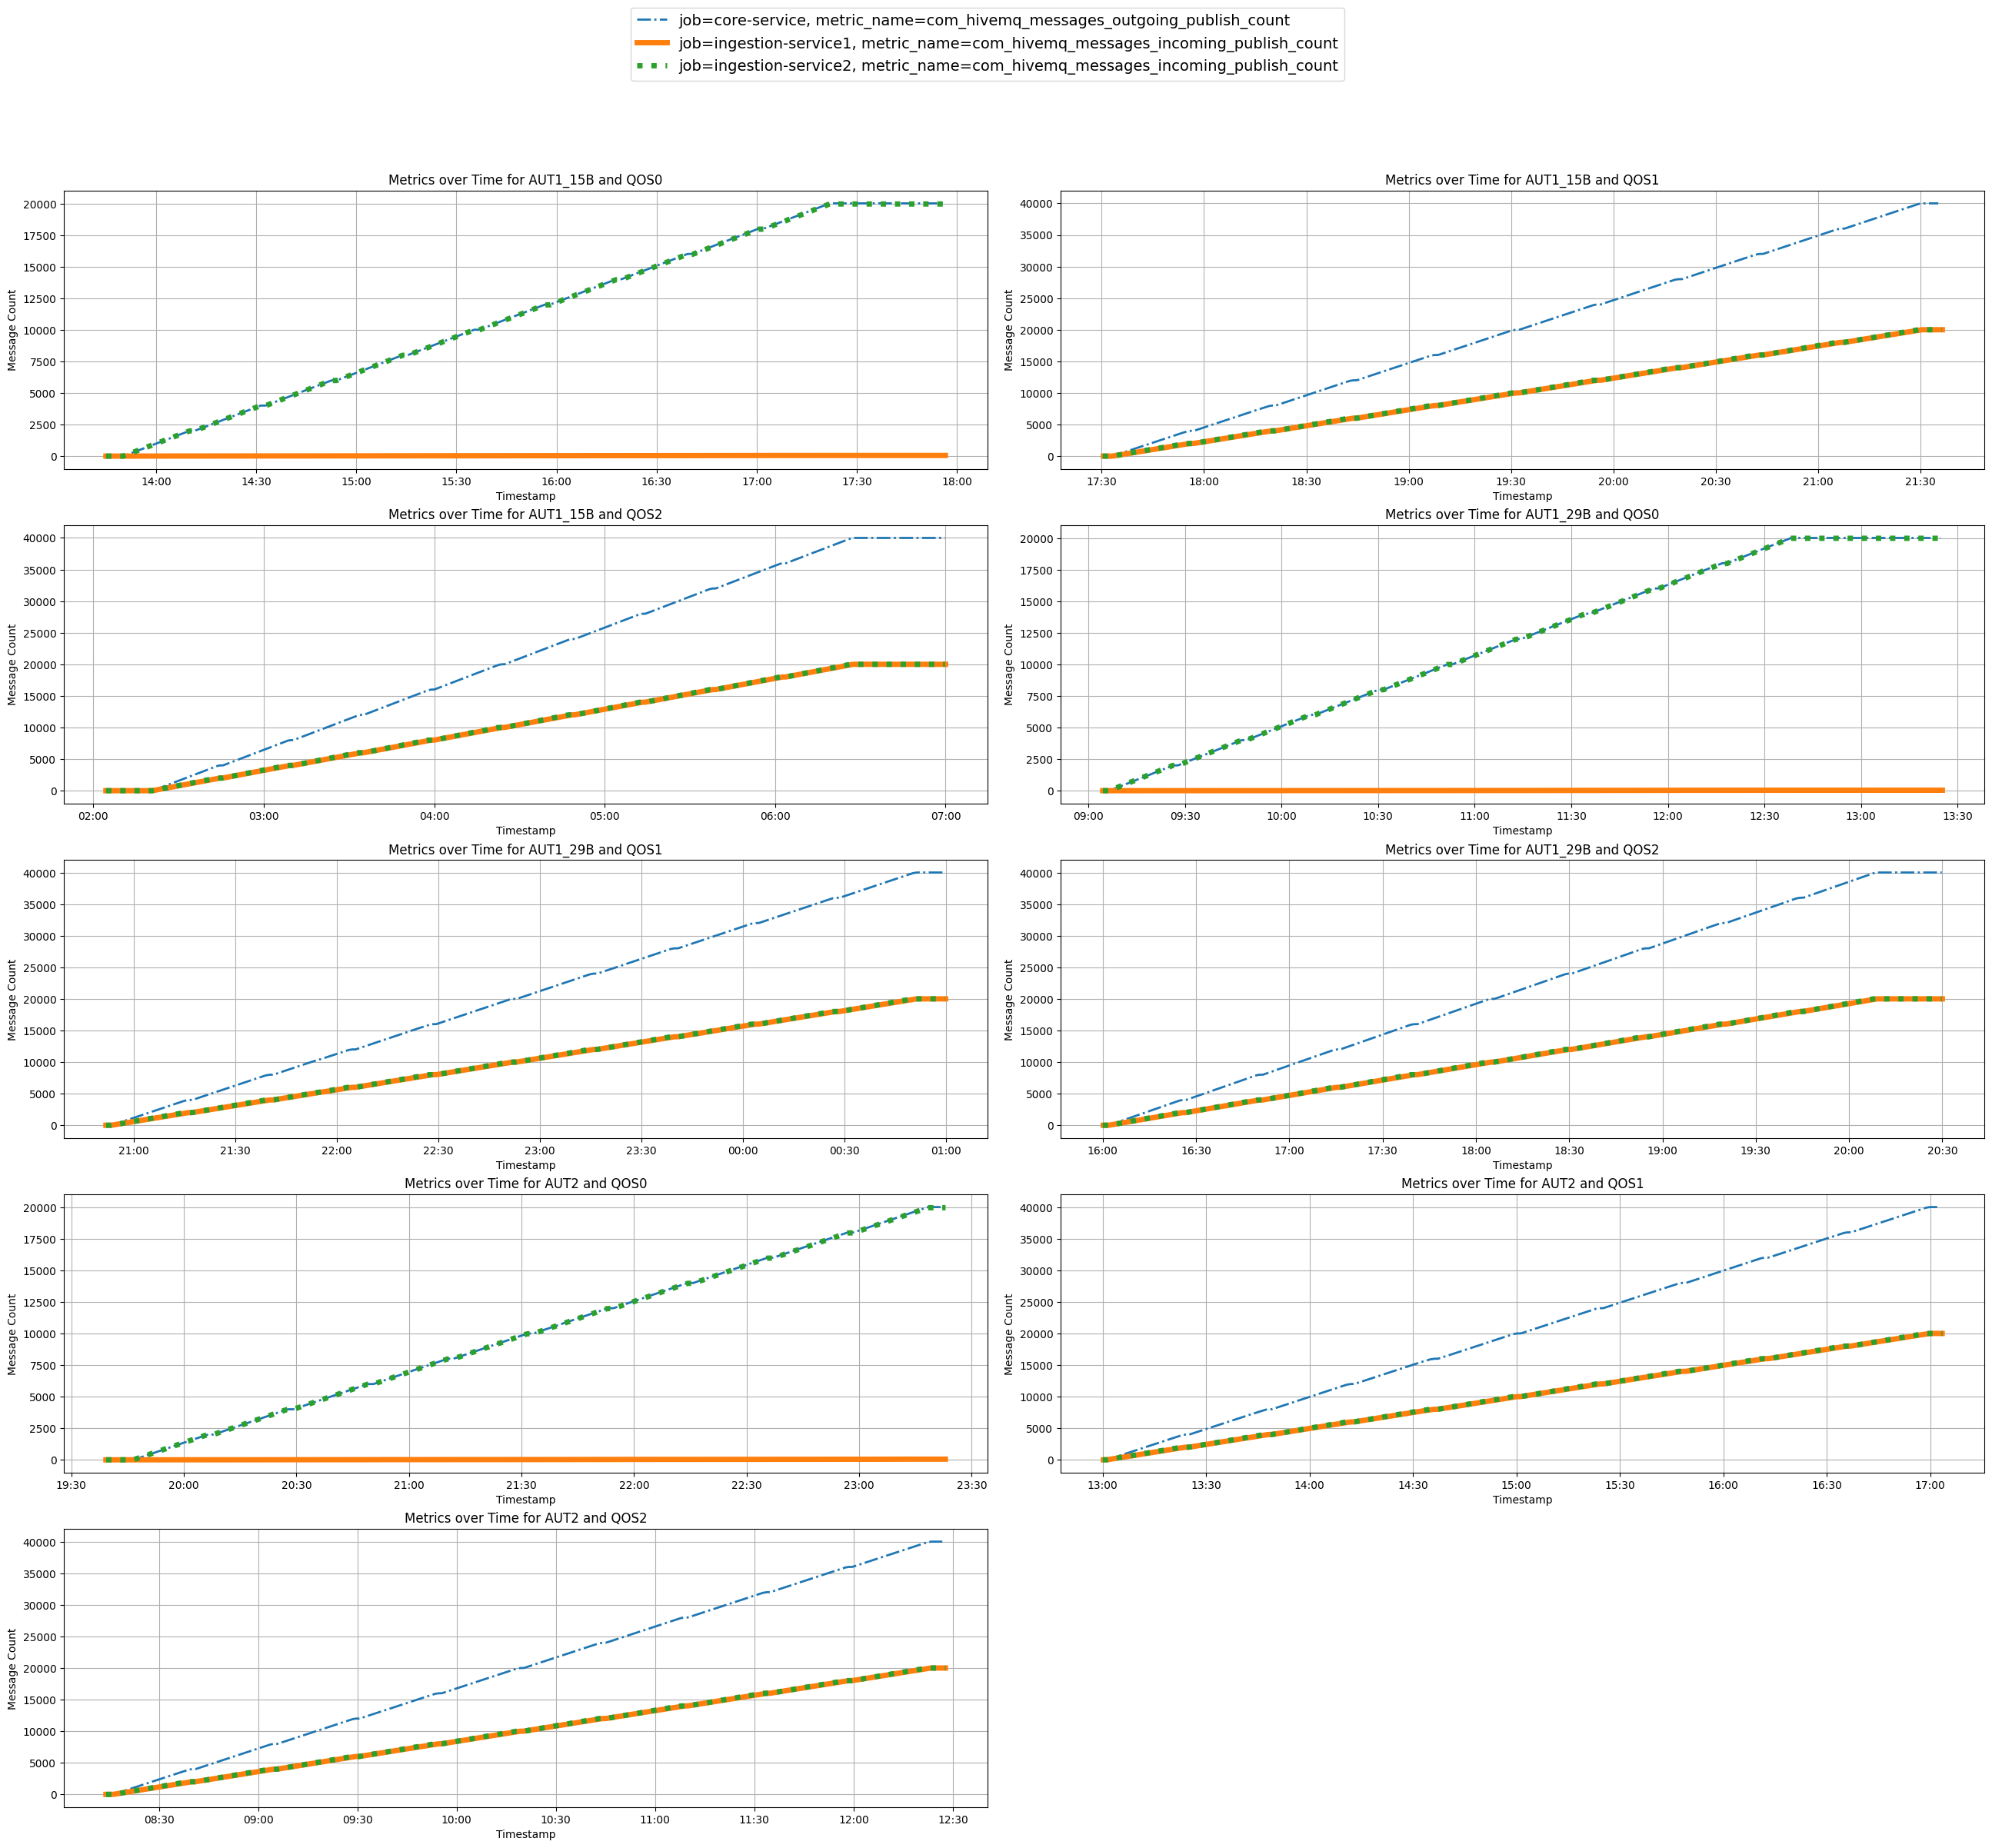

In [46]:
# Define your function for plotting
def plot_time_series_grouped_grid(data_array):
    # Extract unique values for aut and qos
    aut_values = np.unique(data_array['aut'])
    qos_values = np.unique(data_array['qos'])
    job_values = np.unique(data_array['job'])
    metric_name_values = np.unique(data_array['metric_name'])

    num_plots = len(aut_values) * len(qos_values)
    grid_size = (5, 2)  # Define the grid size

    # Create a grid of subplots
    fig, axs = plt.subplots(*grid_size, figsize=(26, 24))
    fig.subplots_adjust(hspace=0.5, wspace=0.7)

    # Flatten the array of axes for easy iteration
    axs = axs.flatten()

    subplot_idx = 0

    # Iterate over each combination of aut and qos
    for aut in aut_values:
        for qos in qos_values:
            ax = axs[subplot_idx]
            ax.set_title(f'Metrics over Time for {aut.upper()} and {qos.upper()}')
            ax.set_xlabel('Timestamp')
            ax.set_ylabel('Message Count')
            ax.grid(True)

            # Iterate through job and metric_name combinations
            unique_combinations = np.array([(job, metric_name) for job in job_values for metric_name in metric_name_values])
            num_combinations = len(unique_combinations)

            for idx, (job, metric_name) in enumerate(unique_combinations):
                group_data = data_array[(data_array['aut'] == aut) & 
                                        (data_array['qos'] == qos) & 
                                        (data_array['job'] == job) & 
                                        (data_array['metric_name'] == metric_name)]
                
                if len(group_data) > 0 and metric_name == 'com_hivemq_messages_incoming_publish_count':
                    if job == 'core-service':
                        continue
                    if job == 'ingestion-service1':
                        ax.plot(group_data['timestamp'], group_data['value'], linestyle='-', 
                                 label=f'job={job}, metric_name={metric_name}', linewidth=5)
                    if job == 'ingestion-service2':
                        ax.plot(group_data['timestamp'], group_data['value'], linestyle=':', 
                                 label=f'job={job}, metric_name={metric_name}', linewidth=5)
                if len(group_data) > 0 and metric_name == 'com_hivemq_messages_outgoing_publish_count':
                    if job != 'core-service':
                        continue
                    ax.plot(group_data['timestamp'], group_data['value'], linestyle='-.', 
                             label=f'job={job}, metric_name={metric_name}', linewidth=2)

            # Format the date on the x-axis
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

            # Update subplot index
            subplot_idx += 1

            # Break loop if we've plotted all required subplots
            if subplot_idx >= num_plots:
                break

    # remove unused axes
    for ax in axs.flat[num_plots:]:
        ax.remove()
    
    # Adjust layout to prevent labels from being cut off
    fig.tight_layout()
    #fig.autofmt_xdate()
    fig.subplots_adjust(top=0.90)  # Add extra space at the top for the legend
    
    # Move the last legend below the plot
    handles, labels = axs.flat[num_plots-1].get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(1, 6.5),fontsize=14, prop={'size': 14})

    # Save plot
    plt.savefig('prometheus_host_machine.png', format='png')

    plt.show()

# Call function with data
plot_time_series_grouped_grid(numpy_array)